Image Dimensions [length, width, bands]: [1741, 1741, 3]


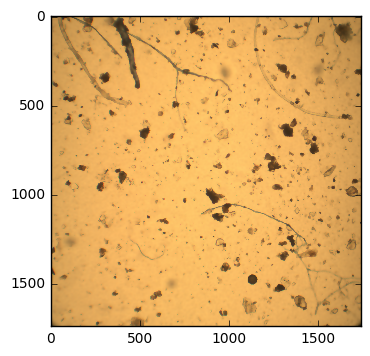

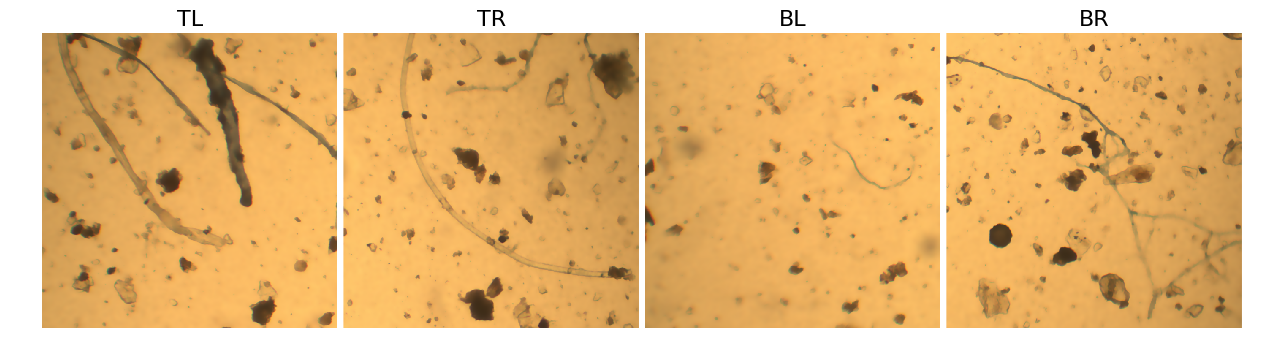

In [178]:
%matplotlib inline

#########################################################################################
dir_in = "/home/patrick/Documents/Test Images for PyRoots/Images/split_images/Settings Tests/Nice Scope/"
file_in = "100x B1.2G1Gamma2_bilat.tif"

# Zoom to these coordinates
zoom_topleft =     {'xmin' : 0,
                    'xmax' : 700,
                    'ymin' : 0,
                    'ymax' : 700}
zoom_topright =    {'xmin' : 1000,
                    'xmax' : 1700,
                    'ymin' : 0,
                    'ymax' : 700}
zoom_bottomleft =  {'xmin' : 0,
                    'xmax' : 700,
                    'ymin' : 1000,
                    'ymax' : 1700}
zoom_bottomright = {'xmin' : 1000,
                    'xmax' : 1700,
                    'ymin' : 1000,
                    'ymax' : 1700}
zoom_topmid = {'xmin' : 600,
               'xmax' : 1300,
               'ymin' : 0,
               'ymax' : 700}
#########################################################################################

from matplotlib import pyplot as plt
from skimage import io, color, filters, draw, morphology, exposure, img_as_int, restoration, measure
import pyroots as pr
import numpy as np
from scipy import ndimage

image = io.imread(dir_in + file_in)

print("Image Dimensions [length, width, bands]: " + str([i for i in image.shape]))

img = image
plt.imshow(img)
zoom_list = [zoom_topleft, zoom_topright, zoom_bottomleft, zoom_bottomright]
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])

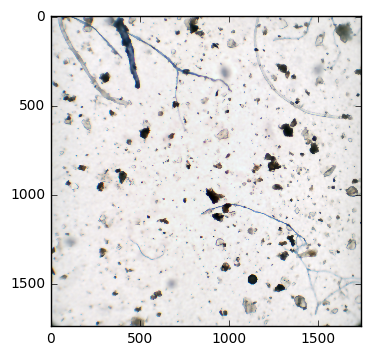

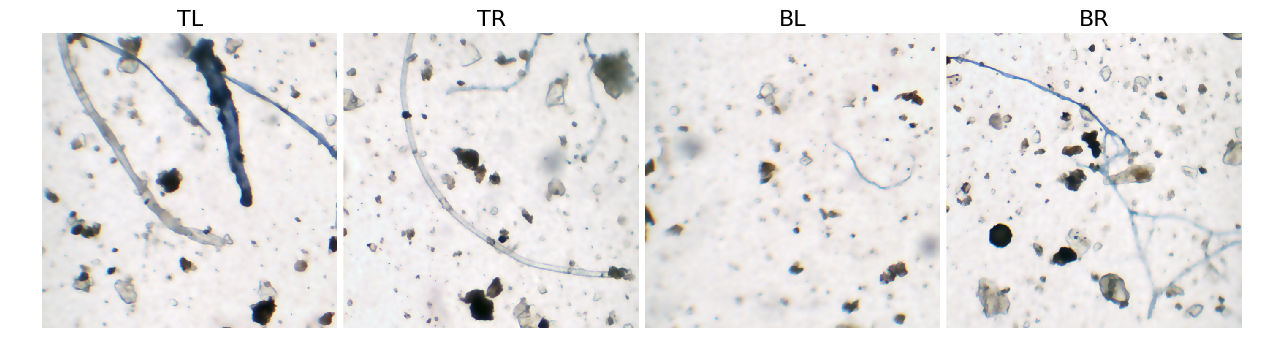

In [179]:
#########################################################################################
equalize_brightness = True  # recommended for image quality
kernel_size = 151
#########################################################################################

if equalize_brightness is True:
    temp = [equalize_exposure(i, kernel_size) for i in pr.img_split(image)]
    out = np.zeros(image.shape)
    for j in range(len(temp)):  # remake into 3d array
        out[:, :, j] = temp[j]
    image = out.copy()

img = image
plt.imshow(img)
zoom_list = [zoom_topleft, zoom_topright, zoom_bottomleft, zoom_bottomright]
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])

## Select the band of the colorspace for identifying candidate objects
The band should show hyphae clearly and consistently. Some distinction between hyphae and non-hyphae objects helps but is not essential. Objects should not be partly outlined in higher (lighter) values - avoid chroma type bands like hue, a and b of lab. For analine blue stain in a microscope, the red band of rgb is good. 

In general, a single band is sufficient for identifying candidate objects. We will use the other information later. 

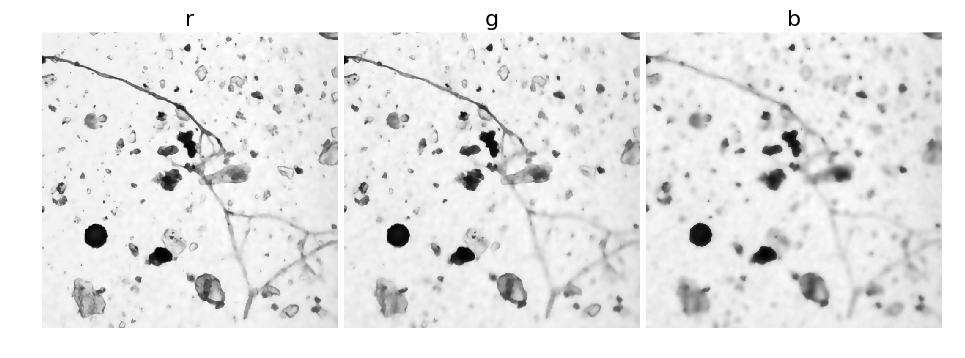

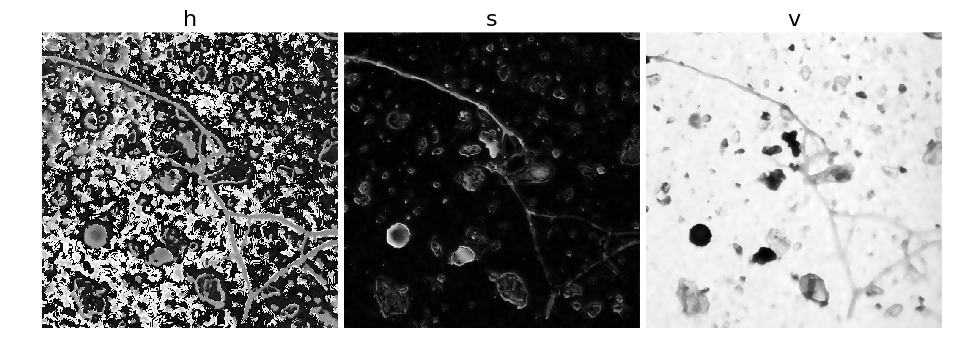

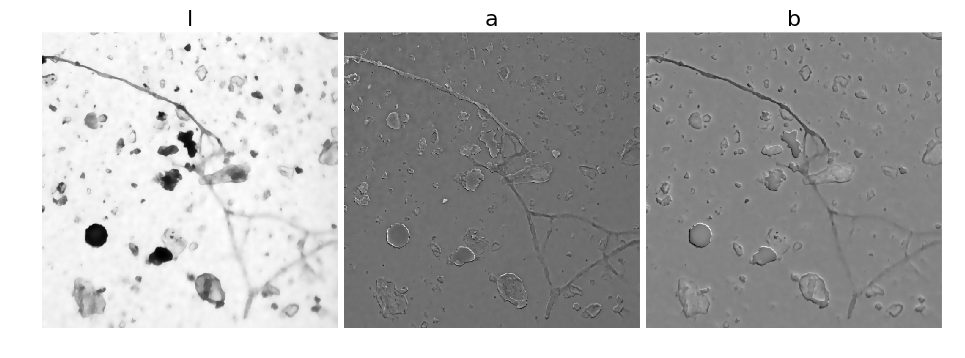

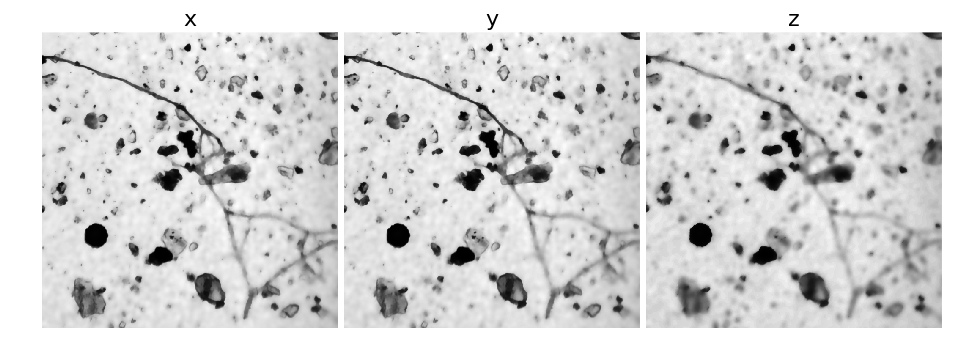

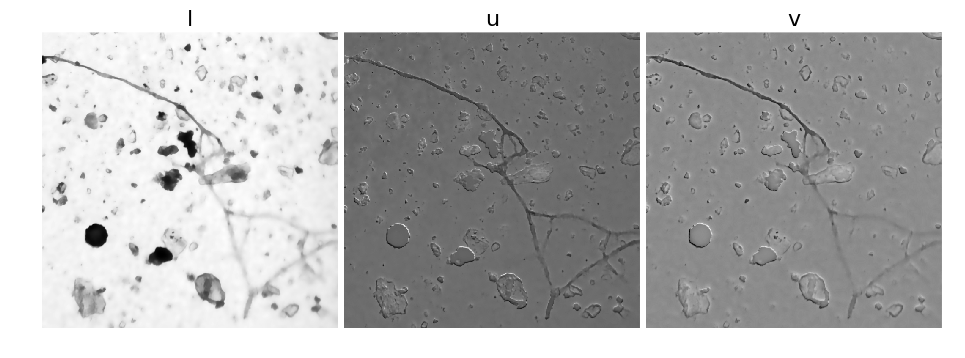

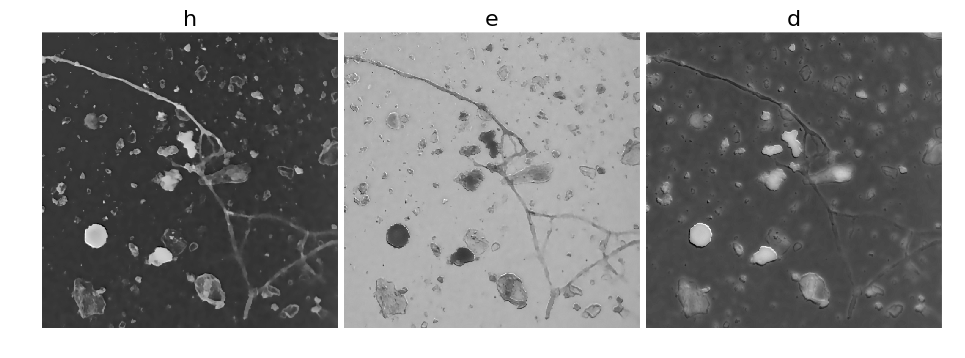

[None, None, None, None, None, None]

In [180]:
####################################################
colorspaces = ['rgb','hsv','lab','xyz','luv', 'hed']  # add or remove whatever you're curious about. See skimage.color.rgb2*()
####################################################

[pr.band_viewer(image, i, zoom_coords = zoom_bottomright) for i in colorspaces]

### Pull out the band of interest

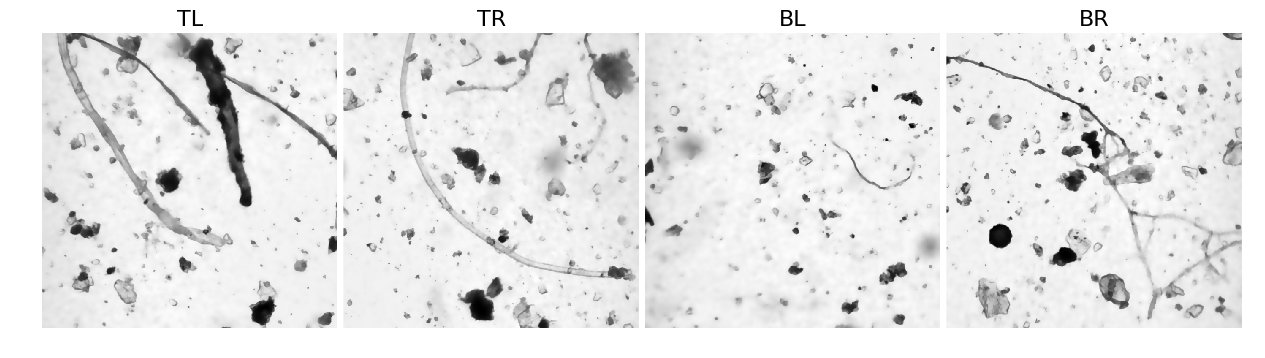

In [192]:
#########################################################################################
colorspace = 'rgb'
analysis_band = 0  # rgb: 0 = red, 1 = green, 2 = blue
#########################################################################################

# convert colorspace if necessary
if colorspace is not 'rgb':
    band = getattr(color, "rgb2" + colorspace)(image)
else:
    band = image.copy()
    
band = pr.img_split(band)[analysis_band]

img = band
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])

## Now run the frangi vessel enhancement filter

The frangi filter enhances ridges/edges of a series of widths and set contrast from neighboring objects. Width is controlled by `sigma`, dictated by `scale_range` and `scale_step`. Sensitivity is controlled by `beta2`.  

Pick a `scale_range` that highlights whole hyphae and edges of larger objects. For hyphae at 100x, a scale range of `(2,6)` works well. `scale_step` should sufficiently cover width classes. `beta1` should be nearly 1 for best behavior. `beta2` controls the sensitivity, and should be set so that objects are clear, and touching objects have an area of 'low' response between them. Expect lots of spurrious, small objects. 

0.999998138112
0.0


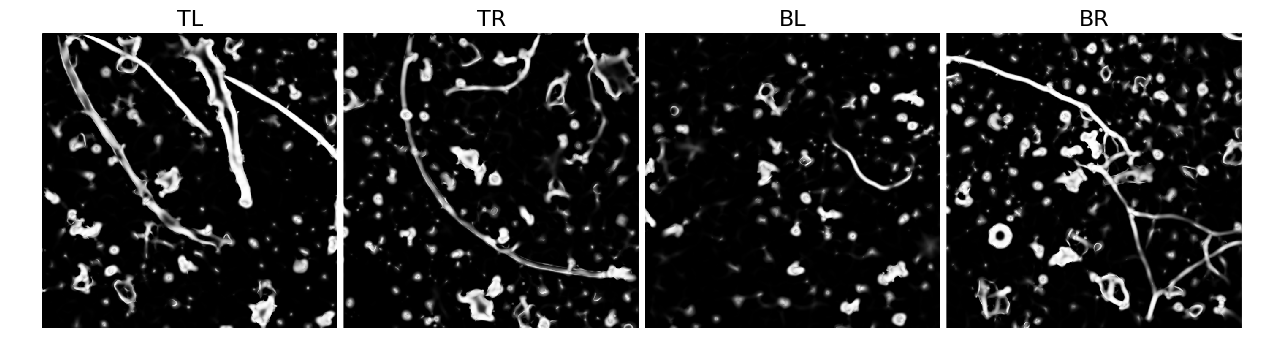

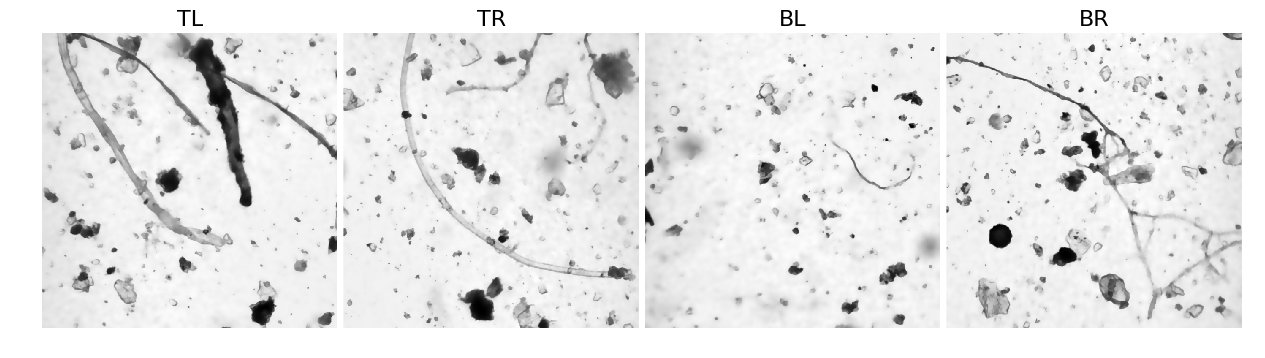

In [193]:
#########################################################################################
frangi_args = {'scale_range'  : (2, 8),  # sigmas for running the filter. Wider enhances wider objects; narrow enhances narrow objects.
               'scale_step'   : 1,       # step between sigmas in the scale range.
               'beta1'        : 0.99,    # correction [0,1] toward linear vs ring-like. Want close to 1.
               'beta2'        : 0.05,    # sensitivity to low-contrast areas
               'black_ridges' : True}    # dark objects on light background?
#########################################################################################


frangi = filters.frangi(band, **frangi_args)  # detect black or white ridges

print(frangi.max())
print(frangi.min())
img = frangi
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])
# img = rescaled[0] > np.percentile(rescaled[0], 98)
img = band
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])

## Adaptive threshold the frangi filter
Now identify objects and edges using an adaptive threshold. The advantage of this is, it separates distinct objects from each other due to their combined high response giving a locally high thresholed. For it to work, the sensitivity of the frangi filter must be low enough to give low responses where objects touch. 

Strategy:
`block_size` : Defines the local neighborhood for thresholding. Should be small enough to be responsive to the local neighborhood, but large enough to avoid splitting wider objects.
`offset` : Sets the threshold for the area. [0, 1]. Highly sensitive. 

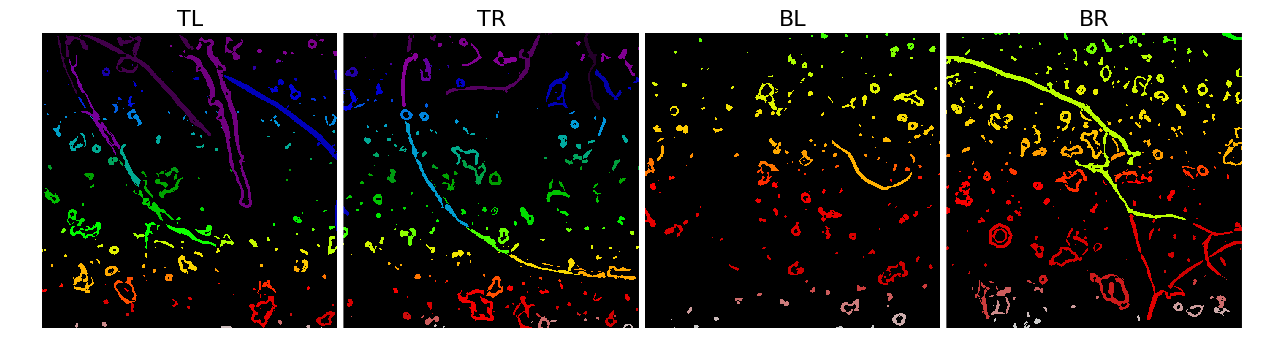

In [194]:
#########################################################################################
threshold_args = {'block_size' : 29,   # small enough to respond strongly to the local neighborhood, large enough to avoid hollowing objects
                  'offset'     : 0.09}  # high enough to separate touching objects, but low enough to maintain connectivity
#########################################################################################

thresh = 1 - (frangi/frangi.max())  # invert, rescale
thresh = ~filters.threshold_adaptive(thresh, **threshold_args)  # invert so objects are True

img = ndimage.label(thresh)[0]
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'], color_map = "spectral")

## Filtering based on morphology

### Filter by geometry: eccentricity, solidity, major axis length, area
* eccentricity: of an ellipse with equivalent moments to the object's convex hull. Should be very high, since hyphae are mostly long and skinny.
* solidity: Percentage of convex hull's area that an object take up. Should be low, since hyphae are curvy and skinny. 
* major axis length: of ellipse with equivalent moments to convex hull. 
* area: in pixels of each object.

Two levels of filters:
1. A 'strict' filter, with stringent eccentricity and solidity thresholds. True objects must pass one.
2. A 'loose' filter, which sets a maximum stringency and minimum eccentricity. True objects must pass both. 

Note that this is imperfect, but the larger true objects should make it through as will some false objects.

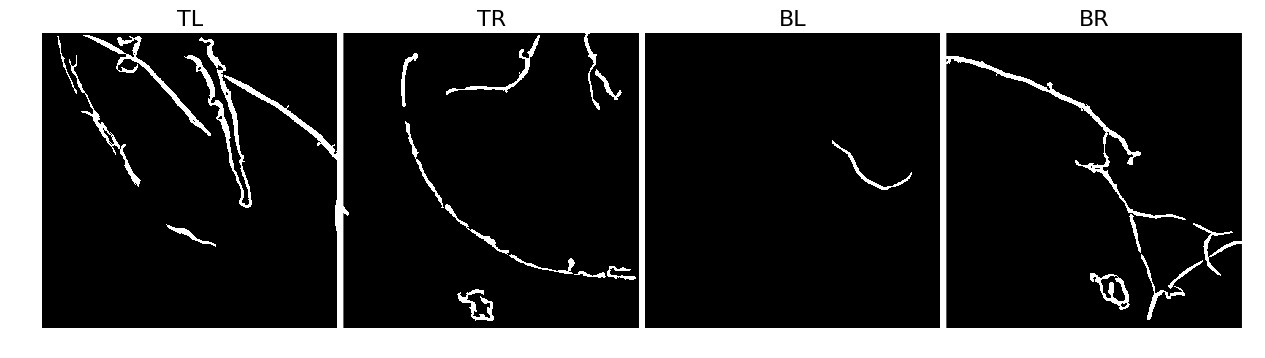

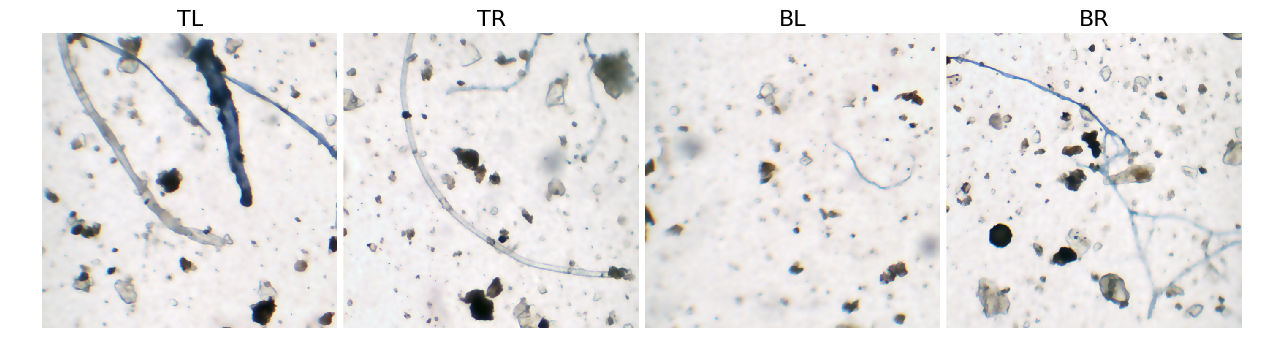

In [195]:
#########################################################################################
morphology_dict = {'loose_eccentricity'  : 0.7,   # This is a floor.
                   'loose_solidity'      : 0.8,   # This is a ceiling.
                   'strict_eccentricity' : 0.95,  # Floor.
                   'strict_solidity'     : 0.3,   # Ceiling.
                   'min_length'          : 100,    # Floor.
                   'min_size'            : 300}   # Floor.
#########################################################################################

morph_filt = morphology_filter(thresh, **morphology_dict)
# print(morph_filt)
img = morph_filt
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])
img = image
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])

### Filter by 'filled'-ness
Rationale: Some objects meet the eccentricity and solidity criteria, but are not true objects. These include really wide objects that were picked up as edges, clear objects with strong parallel edges, etc. These are filtered out by looking at the ratio of their edge length ('perimeter') to their post-filling, medial axis length.

Strategy:
* fill_kernel : Dictates how wide of a gap can be filled. True objects can have loops, but usually they are large compared to edges of larger objects. 
* threshold : maximum perimiter:filled axis ratio. Solid hyphae should have a ratio close to 1; parallel edges a ratio close to 2. 

In [186]:
%psource hollow_filter

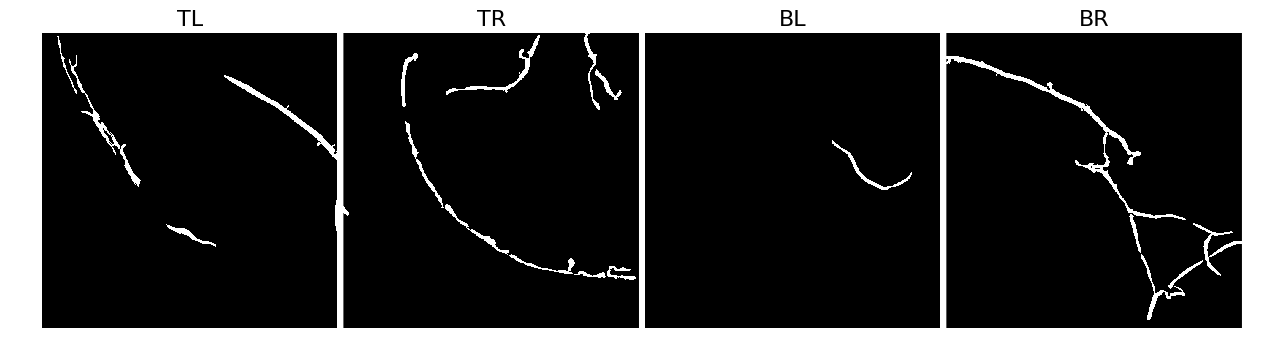

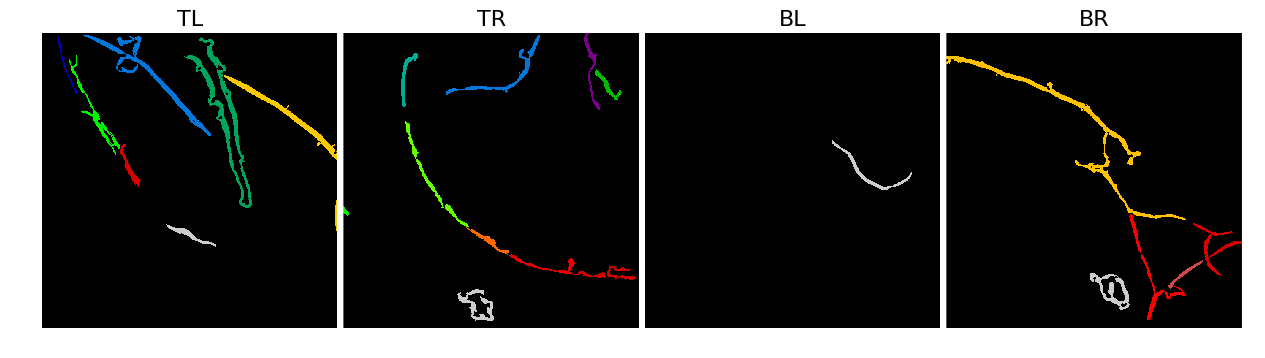

In [198]:
#########################################################################################
hollow_dict = {'ratio'       : 1.3,  # this is a ceiling
               'fill_kernel' : 15}   # radius of disk, in pixels, passed to binary_closing
#########################################################################################

hollow_filt = hollow_filter(morph_filt, **hollow_dict)

img = hollow_filt
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])
img = ndimage.label(morph_filt)[0]
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'], color_map = "spectral")

## Filter objects by color values
If staining, objects should be a consistent color if not a consistent saturation. This provides a way of distinguishing real objects from spurrious ones. 

Strategy:
1. Choose a band where real objects and false objects don't overlap too much. For analine blue-stained hyphae, these bands are blue in RGB, and hue in HSV.
2. Determine the range of values that real objects should take.
3. Set a minimum percentile of pixels in an object that should be within this value range. 

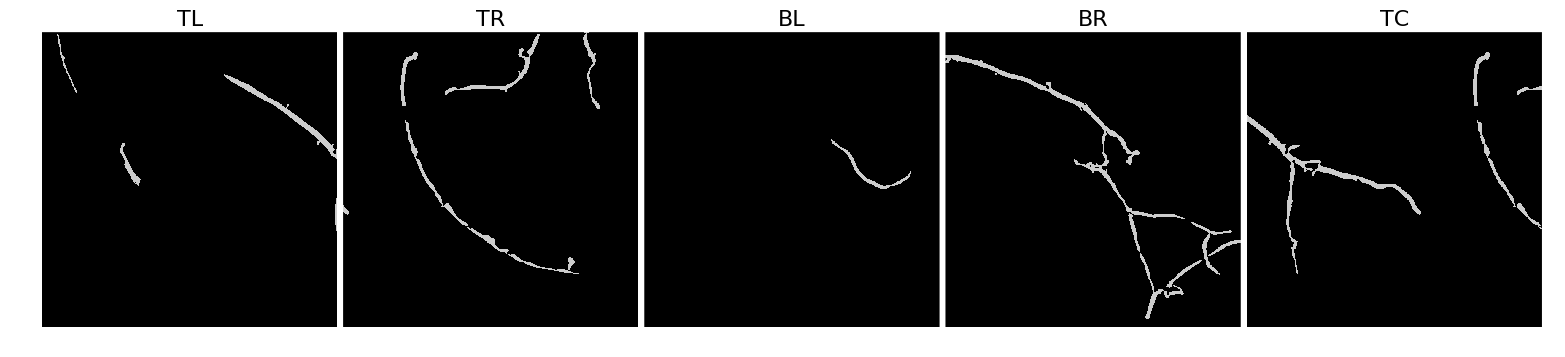

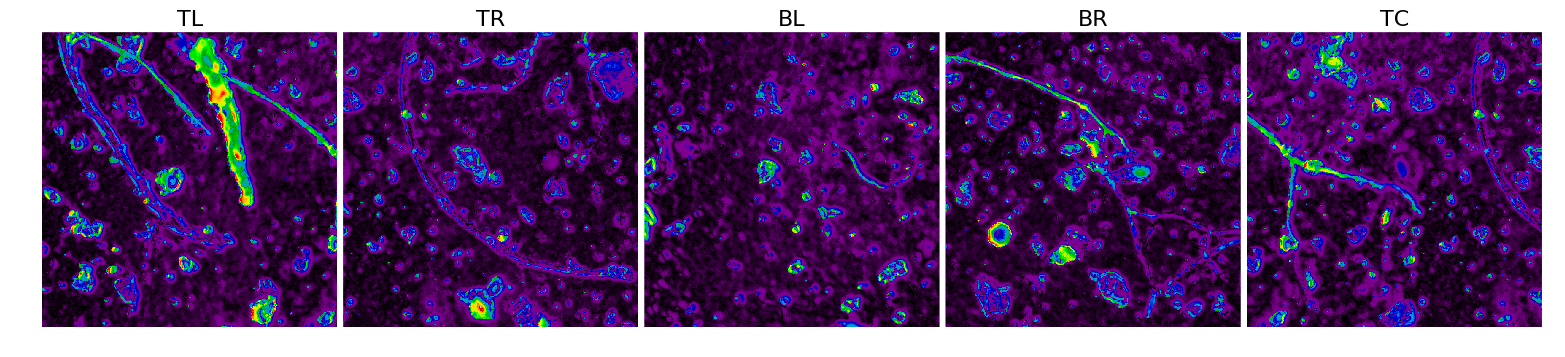

In [199]:
#########################################################################################
color_dict_1 = [{'colorspace' : 'rgb',  # Colorspace from which to select band
                 'band'       : 2},     # Band of colorspace
                
                {'low'     : 0.7,    # minimum of range for color value
                 'high'    : 0.85,   # maximum of range for color value
                 'percent' : 50}]    # minimum percent of all pixels that must fall with the range
#########################################################################################
def color_filter(image, objects, bands_dict, params_dict):
    # convert rgb image if necessary, select band.
    colorband = image.copy()
    if bands_dict['colorspace'] is not 'rgb':
        colorband = getattr(color, "rgb2" + bands_dict['colorspace'])(colorband)

    colorband = pr.img_split(colorband)[bands_dict['band']]

    # Filter color
    out = percentile_in_range(colorband, objects, **params_dict)
    return(out)
    
colorfilt1 = color_filter(image, hollow_filt, color_dict_1[0], color_dict_1[1])  # image is the original input image

img = colorfilt1
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list + [zoom_topmid]], ['TL', 'TR', 'BL', 'BR', 'TC'], color_map="spectral")
img = colorband
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list + [zoom_topmid]], ['TL', 'TR', 'BL', 'BR', 'TC'], color_map="spectral")

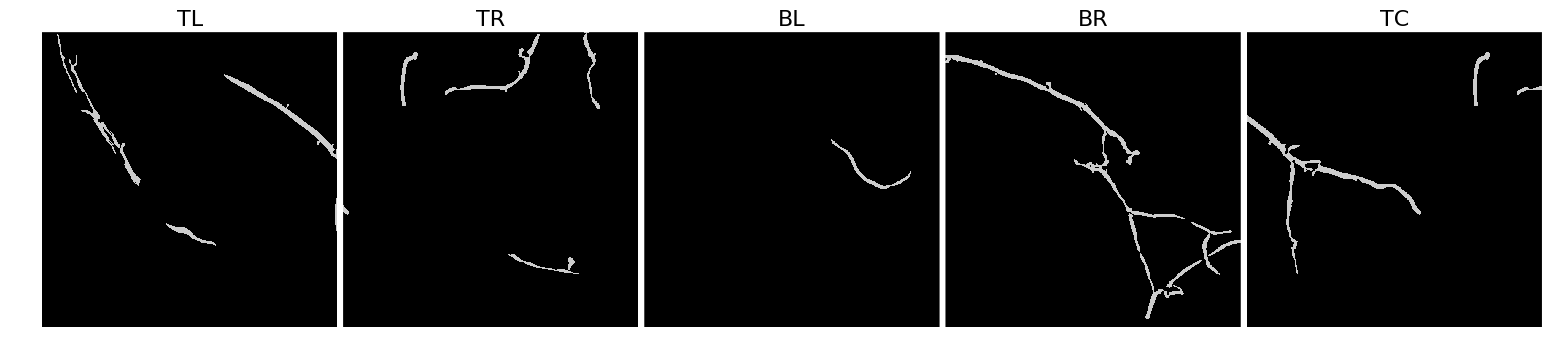

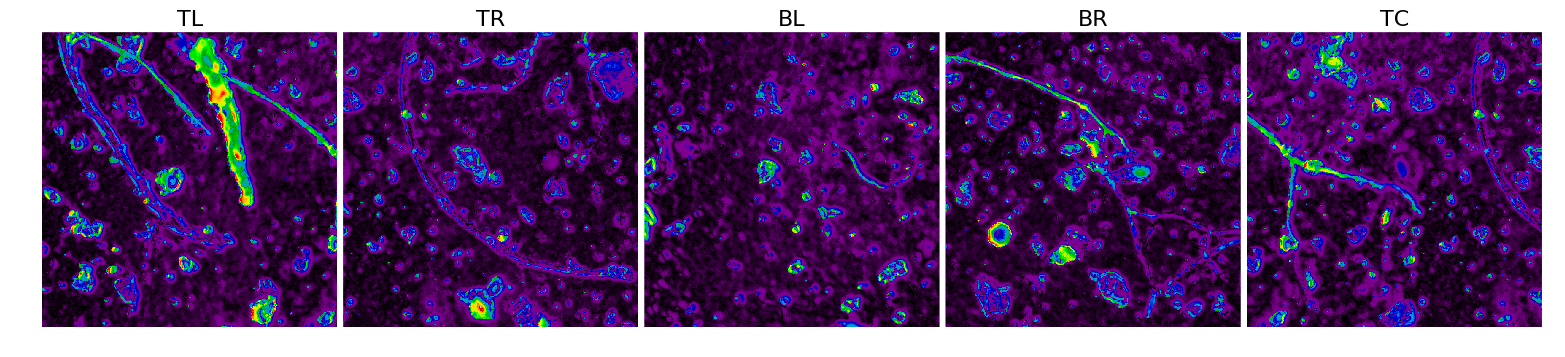

In [200]:
#########################################################################################
color_dict_2 = [{'colorspace' : 'hsv',  # Colorspace from which to select band
                 'band'       : 0},     # Band of colorspace
               
                {'low'     : 0.5,    # minimum of range for color value
                 'high'    : 0.7,    # maximum of range for color value
                 'percent' : 60}]    # minimum percent of all pixels that must fall with the range
#########################################################################################

colorfilt2 = color_filter(image, hollow_filt, color_dict_2[0], color_dict_2[1])

img = colorfilt2
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list + [zoom_topmid]], ['TL', 'TR', 'BL', 'BR', 'TC'], color_map="spectral")
img = colorband
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list + [zoom_topmid]], ['TL', 'TR', 'BL', 'BR', 'TC'], color_map="spectral")

### Combine color filters
Must be in both

#### Check your images
Do the positives and negatives seem to balance? 

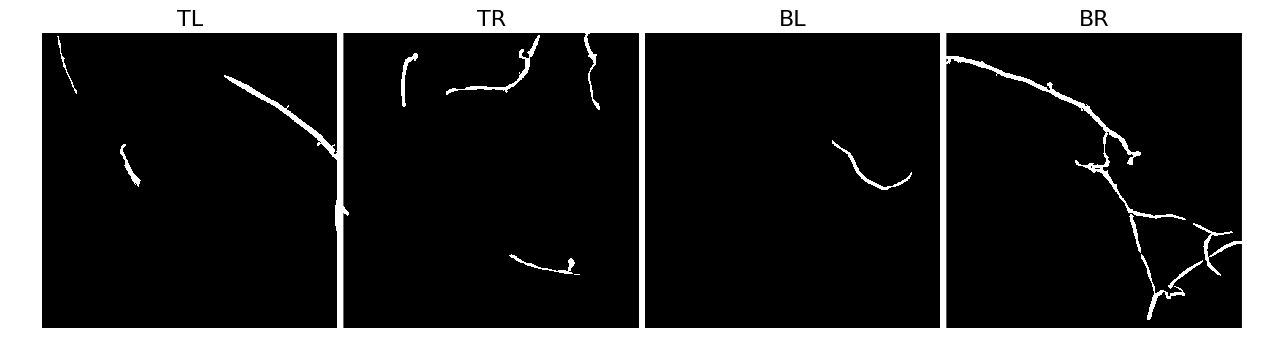

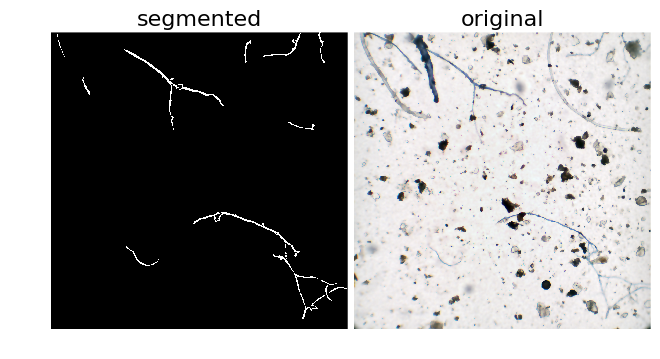

In [201]:
color_filt = colorfilt1 * colorfilt2

img = color_filt
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])
img = [color_filt, image]
pr.multi_image_plot(img, ['segmented', 'original'])

## Fill small holes in remaining objects

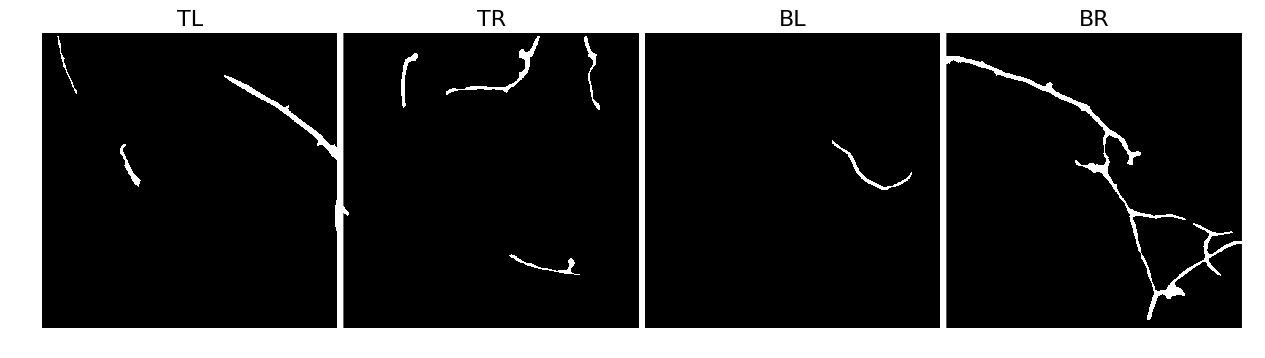

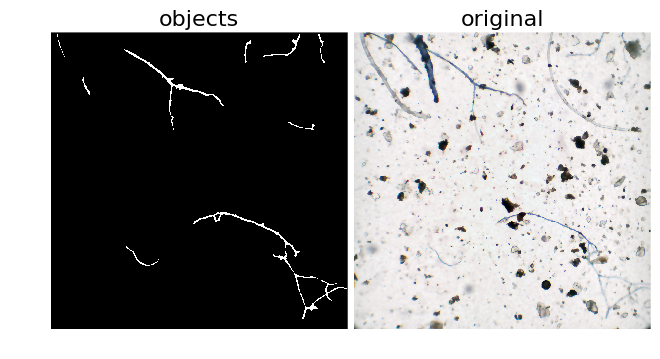

In [169]:
#########################################################################################
hole_filling = {'closing'  : morphology.disk(7),
                'min_size' : 300}
#########################################################################################

holes_filled = morphology.binary_closing(color_filt, hole_filling['closing'])
holes_filled = morphology.remove_small_holes(holes_filled, min_size = hole_filling['min_size'])

img = holes_filled
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])
img = [holes_filled, image]
pr.multi_image_plot(img, ['objects', 'original'])

## Compute skeleton

    Diameter    Length
0   0.000000     0.000
1   4.116468   157.363
2   8.914315   376.375
3   6.994630   202.841
4   9.101273   143.346
5  11.052533  1127.419
6   9.361454   127.914
7   6.201694   218.305
8   9.308965  2168.171
9   7.036872   259.347


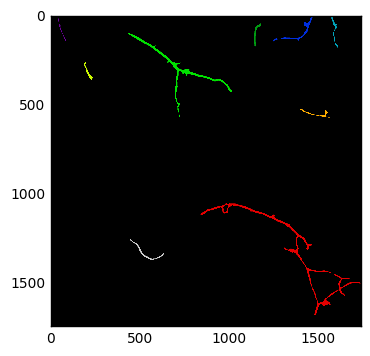

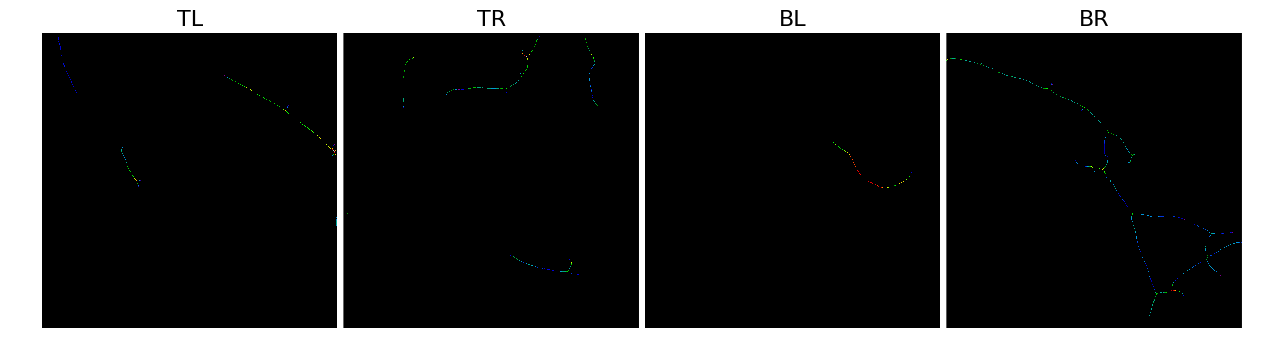

In [176]:
#############################################################
# Nothing to change here
#############################################################

skel = pr.skeleton_with_distance(holes_filled)

print(skel['geometry'])
img = ndimage.label(skel['objects'])[0]
plt.imshow(img, cmap="spectral")
img = skel['diameter']
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'], color_map="spectral")

## Summarize

In [177]:
################################################################
diameter_bins = None
image_name = "image"
################################################################

if diameter_bins is None:
    summary_df = pr.summarize_geometry(skel['geometry'], image_name)

else:
    diam_out, summary_df = pr.bin_by_diameter(diam_dict['length'],
                                              diam_dict['diameter'],
                                              diameter_bins,
                                              image_name)

print(summary_df)

  ImageName    Length  NObjects  MeanDiam
0     image  4781.081         9  9.150004


In [153]:
def morphology_filter(image, loose_eccentricity=0, loose_solidity=1, 
                      strict_eccentricity=0, strict_solidity=1, 
                      min_length=None, min_size=None):
    """
    Defaults are for no filtering
    
    Parameters
    ----------
    image : 2D binary array.
        Candidate objects
    loose_eccentricity, loose_solidity : float
        AND filters. Must pass both levels.
    strict_eccentricity, strict_solidity : float
        OR filters. Must pass one of these
    min_length : int
        in pixels, of ellipse with equivalent moments to convex hull
    min_size : int
        in pixels, of area of candidate object.
    
    Returns
    -------
    2D binary array
    
    See Also
    --------
    `skimage.measure.regionprops`, `ndimage.label`
    """
    
    # Label objects and attach regionprops methods for each label
    labels = ndimage.label(image)[0]
    props = measure.regionprops(labels)

    # calculate eccentricity
    eccentricity = [0] + [i.eccentricity for i in props]
    eccentricity = np.array(eccentricity)[labels]  # make an image based on labels

    # calculate solidity
    solidity = [0] + [i.area / i.convex_area for i in props]
    solidity = np.array(solidity)[labels]  # make an image based on labels
    
    # loose and strict filters
    loose = ((solidity < loose_solidity) * (solidity > 0)) * (eccentricity > loose_eccentricity)  # AND
    strict = ((solidity < strict_solidity) * (solidity > 0)) + (eccentricity > strict_eccentricity)  # OR 
    
    # calculate length
    if min_length is None:
        length = np.ones(image.shape)
    else:
        length = [0] + [i.major_axis_length for i in props]
        length = np.array(length)[labels]  # make an image based on labels
        length = length > min_length
    
    # calculate size
    if min_size is None:
        size = np.ones(image.shape)
    else:
        size = [0] + [i.area for i in props]
        size = np.array(size)[labels]  # make an image based on labels
        size = (size > min_size)       # filter
    
    # Combine and exit. Must pass all. 
    out = strict * loose * length * size  # AND
    return(out)

In [11]:
from skimage import filters, exposure, morphology

def equalize_exposure(image, kernel_size, min_object_size=501, dark_objects=True, bins=256):
    
    # Housekeeping
    img = image.copy()
    
    img_in = img.copy()
    img_mean = np.mean(img)
    
    # mean filter kernel
    kernel = morphology.disk(int(kernel_size/2))
    
    # identify objects to ignore
    objects = filters.threshold_adaptive(img, block_size = 501, offset = 0.01*img.max())
    if dark_objects == True:
        objects = ~objects
    
    objects = morphology.remove_small_objects(objects, min_size = min_object_size)

    # find correction array based on means
    correction = filters.rank.mean(img, selem=kernel, mask = ~objects)
    correction = filters.gaussian(correction, kernel_size)*(bins-1)
    out = img_in + (img_mean - correction)
    out = exposure.rescale_intensity(out, out_range=(0,1))
#     out = np.array(out, dtype=np.uint8)
    
    return(out)

In [187]:
import pyroots as pr
from scipy import ndimage
from skimage import measure, morphology
import numpy as np

def hollow_filter(image, ratio=1.5, fill_kernel=15, **kwargs):
    """
    For each object, what is the ratio of A to B where:
        A = medial axis length before filling (= "perimeter" of hollow objects)
        B = medial axis length after filling (= true medial of hollow objects)
        
    Parameters
    ----------
    image : 2D binary array
        input image. 
    ratio : float
        Maximum of A:B (see above)
    fill_kernel : int
        Radius of disk, in pixels, used to fill objects.
    **kwargs : dict
        passed on to `pyroots.noise_removal`
    
    Returns
    -------
    A 2D binary array
    
    See Also
    --------
    `skimage.morphology.binary_closing`, `pyroots.skeleton_with_distance`, 
    `pyroots.noise_removal`
    """
    
    img = image.copy()
    
    # Labels, object slices
    labels, labels_ls = ndimage.label(img)
    props = measure.regionprops(labels)  # for slicing the image around objects
    
    # Smooth the image. Medial axis is highly sensitive to bumps. 
    skel = pr.noise_removal(img, **kwargs)
    skel = pr.skeleton_with_distance(skel)["length"]  # pull 'length' medial axis of all original objects
    
    test = [0] * (labels_ls + 1)
    for i in range(labels_ls + 1):    
        # Bounds of slice to only the object of interest
        a, b, c, d = props[i-1].bbox
        a = max(a - fill_kernel, 0)  # include a buffer. Stay within bounds of image.
        b = max(b - fill_kernel, 0)
        c = min(c + fill_kernel, img.shape[1])
        d = min(d + fill_kernel, img.shape[0])
        
        # slice objects, original medial axis
        temp = labels[a:c, b:d] == i
        temp_medial = skel[a:c, b:d] * temp
        
        # fill in hollow areas and calculate new medial length
        temp = morphology.binary_closing(temp, selem=morphology.disk(fill_kernel))
        closed_medial = pr.skeleton_with_distance(temp)["length"]
        
        # Does the ratio pass the threshold?
        test[i] = np.sum(temp_medial)/np.sum(closed_medial) < ratio
    
    # update image
    out = np.array(test)[labels] * labels > 0
    return(out)

In [13]:
import skimage as ski
import numpy as np
from scipy import ndimage

def _in_range(image, low, high):
    """
    low : low value
    high : high value. Can be smaller than low for, say, hue in hsv (polar scale)
    value_scale : 1-360 "360", or 0-1 "1"?
    """
    img = ski.img_as_float(image)
    
    # rotate so that low = 0. For polar scales (hue of hsv). Arbitrary for 
    img = img - low
    img_a = img + 1
    img[img<0] = img[img<0] + 1  # negative numbers get moved to the top.
    
    new_high = high - low
    if new_high < 0:
        new_high += 1
    
    out = (img >= 0) * (img <= new_high)
    return(out)


def percentile_in_range(image, objects, low, high, percent):
    """
    image : grayscale
    objects : potential objects. Binary image.
    low : low value of range
    high : high value of range
    percent : percent of pixels within
    circular, bins_scale : for ``pyroots._in_range``
    
    Returns
    -------
    An updated objects image.
    """
    labels = ndimage.label(objects)[0]
    
    # Calculate area of objects
    binary_area = ndimage.sum(objects, labels = labels, index = range(labels.max()+1))
    
    # Calculate number of pixels in range for each object
    in_range = _in_range(image, low, high)      # flag image pixel values
    in_range_area = ndimage.sum(in_range, labels = labels, index = range(labels.max()+1))
       # Calculate area of in-range pixels for each object
    
    # Do percentage of pixels in range meet threshold?
    test = in_range_area/binary_area >= percent/100
    test[0] = False  # background
    
    # update objects
    out_objects = np.array(test)[labels]
    return(out_objects)